# Relax Inc. Take Home Challenge

The data is available as two attached CSV files:
- takehome_user_engagement.csv
- takehome_users.csv

The data has the following two tables:
1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
    - name: the user's name
    - object_id: the user's id
    - email: email address
    - creation_source: how their account was created. This takes on one of 5 values:
        - PERSONAL_PROJECTS: invited to join another user's personal workspace
        - GUEST_INVITE: invited to an organization as a guest (limited permissions)
        - ORG_INVITE: invited to an organization (as a full member)
        - SIGNUP: signed up via the website
        - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    - creation_time: when they created their account
    - last_session_creation_time: unix timestamp of last login
    - opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    - enabled_for_marketing_drip: whether they are on the regular marketing email drip
    - org_id: the organization (group of users) they belong to
    - invited_by_user_id: which user invited them to join (if applicable).
    
    
2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.


## 1. Import packages and load files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import user data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

# import engagement data
engage = pd.read_csv('takehome_user_engagement.csv')

In [4]:
# preview first five rows of user
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
users.shape

(12000, 10)

In [7]:
# rename object_id to user_id for consistency
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [8]:
# convert creation_time to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [9]:
# preview first five rows of engage
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
engage.shape

(207917, 3)

In [12]:
# convert time_stamp to datetime
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

# set time_stamp as index
engage = engage.set_index('time_stamp', drop= True)
engage

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
...,...,...
2013-09-06 06:14:15,11996,1
2013-01-15 18:28:37,11997,1
2014-04-27 12:45:16,11998,1


## 2. Data wrangling

Our first objective will be to create our target variable.

In [13]:
# group engagements by user and resample by day
engage_grouped = pd.DataFrame(engage.groupby('user_id')['visited'].resample('D').count())
engage_grouped

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-16        0
        2013-11-17        0
        2013-11-18        0
...                     ...
11996   2013-09-06        1
11997   2013-01-15        1
11998   2014-04-27        1
11999   2012-06-02        1
12000   2014-01-26        1

[522501 rows x 1 columns]

In [14]:
engage_7 = engage_grouped.groupby('user_id', group_keys=False, as_index=False).rolling(7, min_periods=0).sum()

In [15]:
engage_7

user_id  visited
user_id time_stamp                  
1       2014-04-22        1      1.0
2       2013-11-15        2      1.0
        2013-11-16        2      1.0
        2013-11-17        2      1.0
        2013-11-18        2      1.0
...                     ...      ...
11996   2013-09-06    11996      1.0
11997   2013-01-15    11997      1.0
11998   2014-04-27    11998      1.0
11999   2012-06-02    11999      1.0
12000   2014-01-26    12000      1.0

[522501 rows x 2 columns]

In [16]:
#drop redundant 'user_id' column
engage_7.drop('user_id', axis=1, inplace=True)

In [17]:
# Compute max number of visits for each user for seven-rolling-day periods.
engage_max = engage_7.groupby('user_id')[['visited']].max()

In [18]:
engage_max

,visited
user_id,
1,1.0
2,3.0
3,1.0
4,1.0
5,1.0
...,...
11996,1.0
11997,1.0
11998,1.0


In [19]:
engage_max[engage_max['visited']>=3]

,visited
user_id,
2,3.0
10,7.0
20,3.0
33,3.0
42,7.0
...,...
11965,4.0
11967,7.0
11969,7.0


In [20]:
# Add target column 'adopted'
engage_max.loc[engage_max['visited'] >= 3, 'adopted_user'] = 1
engage_max.loc[engage_max['visited'] < 3, 'adopted_user'] = 0

# drop visited column
engage_max.drop('visited', axis=1, inplace=True)

In [21]:
# merge with user dataframe
df = users.merge(engage_max, how='left', on='user_id', sort=True)
df

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0


In [22]:
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  3177
dtype: int64

It seems that we have 3177 missing values for 'last_session_creation_time' and 'adopted_user'.  It's likely that these are the same rows, given that 'adopted_user' was formed by searching through users who have logged on at least once.  We'll check just in case.

In [23]:
# filter for rows where adopted_user is null and check null counts.
df[df['adopted_user'].isnull()].isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            1536
adopted_user                  3177
dtype: int64

There seems to be 3177 rows without usage data.  We do not know whether this data is missing, or if it represents a user who has not logged on since signing up.  In a real situation, we would bring this issue back to the client or stakeholders to determine if these missing values have any significance.  In this case, we will drop these rows.

In [24]:
# filter for rows where adopted_user is not null
df = df[df['adopted_user'].notna()]

#check null counts again
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
adopted_user                     0
dtype: int64

Seems like we have 4047 users have not been invited by another user.  We will leave these values as Nan.

## 3. Exploratory data analysis

We'll start by creating a new feature called 'usage_length', taken by subtracting the last_session_creation_time by the creation_time.

In [25]:
# convert unix time to datetime
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'],unit='s')

In [26]:
# find difference between these two timestamps
df['usage_length'] = df['last_session_creation_time'] - df['creation_time']

#convert to days
df['usage_length']=df['usage_length'].dt.days

We'll take a look at how 'usage_length' differs for adopted users vs non-adopted users

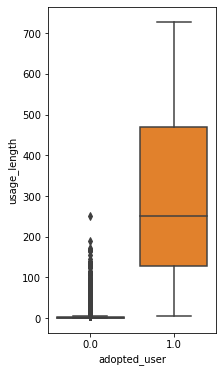

In [27]:
plt.figure(figsize=(3, 6))
sns.boxplot(x=df['adopted_user'], y = df['usage_length'])
plt.show()

There is definitely a significant difference in usage length between adopted users and non-adopted users.

In [28]:
# analyze percentages of creation_source for adopted users
source_ad = df[df['adopted_user']==1]['creation_source'].value_counts(normalize=True).sort_index()

# analyze percentages of creation_source for non-adopted users
source_nonad = df[df['adopted_user']==0]['creation_source'].value_counts(normalize=True).sort_index()

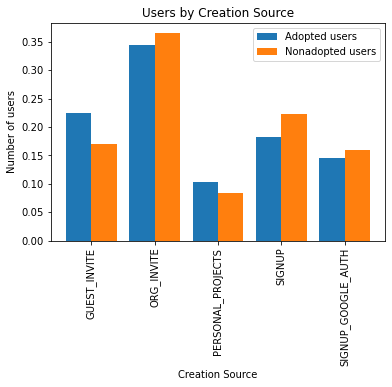

In [29]:
# graph bar plot of creation source for adopted and non adopted users
X = source_ad.index
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, source_ad, width = 0.4, label = 'Adopted users')
plt.bar(X_axis+0.2, source_nonad, width = 0.4, label = 'Nonadopted users')
plt.xticks(X_axis, X, rotation=90)
plt.xlabel('Creation Source')
plt.ylabel('Number of users')
plt.title('Users by Creation Source')
plt.legend()
plt.show()

There don't seem to be too many differences here.  The top three creation sources for adopted and non-adopted users have only one difference:

<u>Top three creation sources for adopted users:</u>
1. ORG_INVITE
2. GUEST_INVITE
3. SIGNUP

<u>Top three creation sources for nonadopted users:</u>
1. ORG_INVITE
2. SIGNUP
3. GUEST_INVITE

In [30]:
# analyze percentages of opted_in_to_mailing_list for adopted users
mailing_ad = df[df['adopted_user']==1]['opted_in_to_mailing_list'].value_counts(normalize=True).sort_index()

# analyze percentages of creation_source for non-adopted users
mailing_nonad = df[df['adopted_user']==0]['opted_in_to_mailing_list'].value_counts(normalize=True).sort_index()


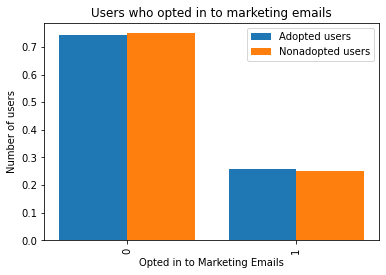

In [31]:
# graph bar plot of marketing email opt in for adopted and non adopted users
X = mailing_ad.index
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, mailing_ad, width = 0.4, label = 'Adopted users')
plt.bar(X_axis+0.2, mailing_nonad, width = 0.4, label = 'Nonadopted users')
plt.xticks(X_axis, X, rotation=90)
plt.xlabel('Opted in to Marketing Emails')
plt.ylabel('Number of users')
plt.title('Users who opted in to marketing emails')
plt.legend()
plt.show()

There is no discernible difference in 'opted_in_to_mailing_list' between adopted users and nonadopted users. 

In [32]:
# analyze percentages of enabled_for_marketing_drip for adopted users
drip_ad = df[df['adopted_user']==1]['enabled_for_marketing_drip'].value_counts(normalize=True).sort_index()

# analyze percentages of enabled_for_marketing_drip for non-adopted users
drip_nonad = df[df['adopted_user']==0]['enabled_for_marketing_drip'].value_counts(normalize=True).sort_index()



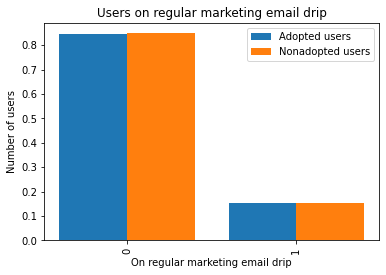

In [33]:
# graph bar plot of marketing email drip for adopted and non adopted users
X = drip_ad.index
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, drip_ad, width = 0.4, label = 'Adopted users')
plt.bar(X_axis+0.2, drip_nonad, width = 0.4, label = 'Nonadopted users')
plt.xticks(X_axis, X, rotation=90)
plt.xlabel('On regular marketing email drip')
plt.ylabel('Number of users')
plt.title('Users on regular marketing email drip')
plt.legend()
plt.show()

There is no discernible difference in 'enabled_for_marketing_drip' between adopted users and nonadopted users. 

Next we'll see the relationship between users who were referred by another user and whether they are adopted users or not.  We'll create a new binary feature called 'referred', where 0 represents that the user was not referred and 1 represents that the user was referred.

In [34]:
df['referred'] = np.where(df['invited_by_user_id'].isnull(), 0, 1)

In [35]:
# analyze percentages of referred for adopted users
referred_ad = df[df['adopted_user']==1]['referred'].value_counts(normalize=True).sort_index()

# analyze percentages of referred for non-adopted users
referred_nonad = df[df['adopted_user']==0]['referred'].value_counts(normalize=True).sort_index()

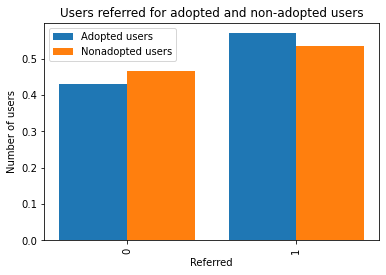

In [36]:
# graph bar plot of referred for adopted and non adopted users
X = referred_ad.index
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, referred_ad, width = 0.4, label = 'Adopted users')
plt.bar(X_axis+0.2, referred_nonad, width = 0.4, label = 'Nonadopted users')
plt.xticks(X_axis, X, rotation=90)
plt.xlabel('Referred')
plt.ylabel('Number of users')
plt.title('Users referred for adopted and non-adopted users')
plt.legend()
plt.show()

Both adopted users and non-adopted users have more who are referred than not referred.  Out of those who are referred, there is a greater percentage of adopted users.  Out of those who are not referred, there is a greater percentage of non-adopted users.

## 4. Preprocessing

In [37]:
# get dummy variables
df = pd.get_dummies(df, columns=['creation_source'])

In [38]:
# drop columns
cols_drop = ['user_id', 
             'creation_time', 
             'name', 
             'email', 
             'last_session_creation_time',
             'org_id',
             'invited_by_user_id'
            ]

# Remove two columns name is 'C' and 'D'
df = df.drop(cols_drop, axis = 1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            8823 non-null   int64  
 1   enabled_for_marketing_drip          8823 non-null   int64  
 2   adopted_user                        8823 non-null   float64
 3   usage_length                        8823 non-null   int64  
 4   referred                            8823 non-null   int64  
 5   creation_source_GUEST_INVITE        8823 non-null   uint8  
 6   creation_source_ORG_INVITE          8823 non-null   uint8  
 7   creation_source_PERSONAL_PROJECTS   8823 non-null   uint8  
 8   creation_source_SIGNUP              8823 non-null   uint8  
 9   creation_source_SIGNUP_GOOGLE_AUTH  8823 non-null   uint8  
dtypes: float64(1), int64(4), uint8(5)
memory usage: 714.7 KB


In [40]:
# separate X and y
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']

In [41]:
# save column names
X_cols = list(X.columns)

We'll identify how many of each class we have in our target.

In [42]:
y.value_counts(normalize=True)

0.0    0.818429
1.0    0.181571
Name: adopted_user, dtype: float64

Given the imbalanced nature of this dataset, we'll make sure to stratify our train test split

In [43]:
# Split the data into train and test sets.
# set stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=16, 
                                                    stratify = y)

In [44]:
# scale data

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 5. Modeling

We'll use Logistic Regression, Random Forest, and XGBoost algorithms to compare.

In [45]:
lr = LogisticRegression(solver='liblinear')

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [46]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [47]:
xg = XGBClassifier(eval_metric = 'logloss')

xg.fit(X_train, y_train)

y_pred_xg = xg.predict(X_test)

In [48]:
print('Logistic Regression')
print(classification_report(y_test,y_pred_lr))
print('Random Forest')
print(classification_report(y_test,y_pred_rf))
print('XGBoost')
print(classification_report(y_test,y_pred_xg))

Logistic Regression
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1445
         1.0       0.93      0.90      0.91       320

    accuracy                           0.97      1765
   macro avg       0.95      0.94      0.95      1765
weighted avg       0.97      0.97      0.97      1765

Random Forest
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1445
         1.0       0.86      0.88      0.87       320

    accuracy                           0.95      1765
   macro avg       0.92      0.92      0.92      1765
weighted avg       0.95      0.95      0.95      1765

XGBoost
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1445
         1.0       0.92      0.88      0.90       320

    accuracy                           0.96      1765
   macro avg       0.95      0.93      0.94      1765
weighted avg       0.96      0.9

In [49]:
# generate confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xg = confusion_matrix(y_test, y_pred_xg)

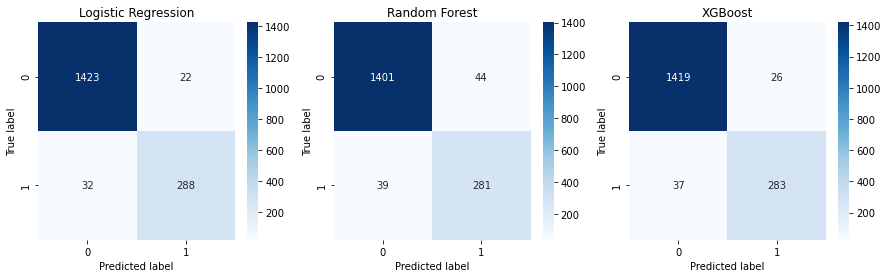

In [50]:
# plot confusion matrices

fig, ax = plt.subplots(1,3, figsize=(15,4))

sns.heatmap(cm_lr, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Logistic Regression')

sns.heatmap(cm_rf, annot=True, fmt = '', cmap = 'Blues',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('Random Forest')

sns.heatmap(cm_xg, annot=True, fmt = '', cmap = 'Blues',ax = ax[2])
ax[2].set_xlabel('Predicted label')
ax[2].set_ylabel('True label')
ax[2].set_title('XGBoost')

plt.show()

In [51]:
# define a function to plot the ROC curve
def roc_plot(clf, label):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr,_ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, 
             label = label + ' AUC: ' + str(round(roc_auc_score(y_score = y_pred_proba, y_true = y_test), 4)))
    

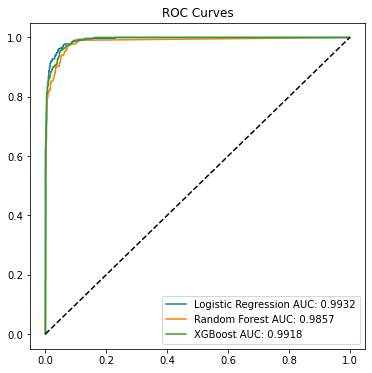

In [52]:
plt.figure(figsize = (6, 6))
roc_plot(lr, 'Logistic Regression')
roc_plot(rf, 'Random Forest')
roc_plot(xg, 'XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.legend(loc='best', frameon=True)
plt.show()

Our logistic regression model performs the best, with the highest value for accuracy of 97% as well as the highest value for AUROC of 0.9933.

## 6. Feature Impact

We'll look at the coefficients of the Logistic Regression model to see how the features affect the target.

In [53]:
importance = lr.coef_[0]
importance

array([ 1.49967503e-01, -2.50147570e-02,  7.95655747e+00,  3.42012986e-03,
        2.08775491e-02, -1.30914530e-02, -4.23214149e-02,  6.91960952e-03,
        2.04255961e-02])

In [54]:
coeffs = pd.DataFrame(zip(X_cols, importance), columns = ['Feature', 'Coefficient'])

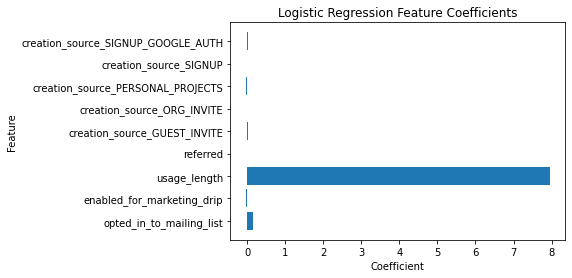

In [55]:
plt.barh(coeffs['Feature'], coeffs['Coefficient'])
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

Based on the coefficients of our Logistic Regression model, it's clear that coefficient for 'usage_length' has the largest magnitude.  This indicates that the difference in time from when a user first created their account to the last time they logged in has the greatest positive impact on the liklihood that a user will be an adopted user.

As a result, we would recommend that Relax find ways to incentivize users to stay active long after they first created their account.
